<h1><center>Исследование объявлений о продаже квартир</center></h1>

На основе данных из архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет нужно научиться определять рыночную стоимость объектов недвижимости. Задачей проекта явлется выяснение параметров, влияющих на стоимость квартиры, которые позволят построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.   

**Цель исследования** — установить параметры, влияющие на рыночную стоимость квартир.  

**Ход исследования**

1. [Обзор данных](#Обзор-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Исследование данных](#Исследование-данных)
4. [Вывод](#Общий-вывод)

## Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')

In [3]:
# выключил ограничение отображения таблиц для личного удобства

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

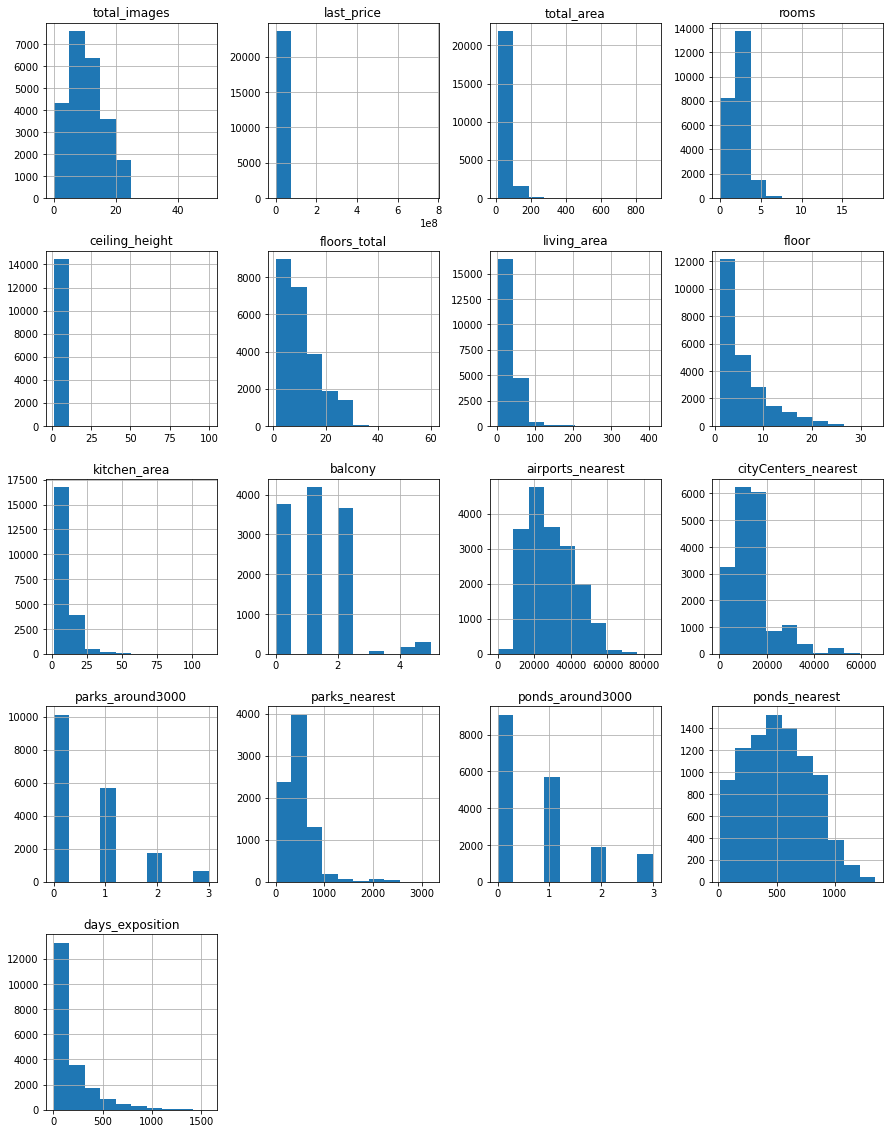

In [6]:
# распределения числовых данных

data.hist(figsize=(15, 20))
plt.show()

**Вывод:** В ходе предварительного знакомства с данными было установлено, что имеется 14 колонок с пропусками. Судя по гистограммам 8 колонок имеют существенные выбросы или в определённых диапазонах недостаёт данных, все данные имеют разные типы распределений. 4 колонки с категориальными данными, одна содержит даты. Типы данных неверные - колонка с датами имеет тип object, колонки которые по логике должны содержать только целочисленные значения (например floors_total, сомневаюсь что можно встретить дом где 2.5 этажа) имеют тип float64.

## Предобработка данных

In [7]:
# изучаем названия столбцов

data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [8]:
# приведение названия столбцов к "snake_case"

data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest',
                            'parks_around3000': 'parks_around_3000',
                            'ponds_around3000': 'ponds_around_3000'})

**Обработка пропусков**

В ходе знакомства с данными было установлено что пропуски имеются в 14 столбцах:

* ceiling_height - высота потолков | полностью случайные пропуски
* floors_total - кол-во этажей | полностью случайные пропуски
* living_area - жилая площадь | случайные пропуски
* kitchen_area - площадь кухни | случайные пропуски
* is_apartment - тип 'апартаменты' | полностью случайные пропуски
* balcony - наличие балкона | случайные пропуски
* locality_name - местоположение | полностью случайные пропуски
* airports_nearest - расстояние до ближайшего аэропорта | случайные пропуски
* city_centers_nearest - расстояние до центра | возможны неслучайные пропуски (если квартира в центре)
* parks_around_3000 - кол-во парков в радиусе 3 км | возможны случайные пропуски (например если ближайший парк дальше чем за 3 км)
* parks_nearest - расстояние до ближайшего парка | возможны случайные пропуски
* ponds_around_3000 - кол-во водоёмов в радиусе 3 км | возможны случайные пропуски
* ponds_nearest - расстояние до ближайшего водоёма | возможны случайные пропуски
* days_exposition - время до снятия объявления (в днях) | полностью случайные пропуски

In [9]:
# пропуски немногочисленны, поэтому избавляемся от них

data.dropna(subset=['locality_name'], inplace=True)

In [10]:
# кол-во пропусков в ceiling_height

data['ceiling_height'].isna().sum()

9160

In [11]:
# заменяем пропуски в значении потолков медианным значением для каждой группы

data["ceiling_height"] = data["ceiling_height"].fillna(
    data.groupby("floors_total")["ceiling_height"].transform("median")
)

In [12]:
# проверяем

data['ceiling_height'].isna().sum()

77

In [13]:
# кол-во пропусков в floors_total

data['floors_total'].isna().sum()

85

In [14]:
# исключаем пропуски в столбце с кол-вом этажей

data.dropna(subset=['floors_total'], inplace=True)

In [15]:
# изучим какой процент от общей площади чаще всего лежит за суммой площади кухни и жилплощади

((data['total_area'] - (data['living_area'] + data['kitchen_area'])) / data['total_area']).median()

0.25

In [16]:
# 1 - 0.25 = 0.75, 75% в основном от общей площади занимают кухня и жилплощадь, заполним недостающие значения

data.loc[data['living_area'].isna(), 'living_area'] = (data['total_area'] * 0.75) - data['kitchen_area']

In [17]:
# то же для кухни

data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = (data['total_area'] * 0.75) - data['living_area']

In [18]:
# замена пропусков в колонке с кол-вом балконов на 0, полагаем что пропуск означает что балкона нет

data['balcony'] = data['balcony'].fillna(0)

In [19]:
# airports_nearest возможно вблизи данного пункта нет аэропортов

data['airports_nearest'].isna().sum()

5524

In [20]:
# city_centers_nearest возможно квартира находится в центре

data['city_centers_nearest'].isna().sum()

5501

In [21]:
# возможно пропуски означают отсутствие парков с радиусе 3 км

data['parks_around_3000'].fillna(0, inplace=True)

In [22]:
# parks_nearest в этой колонке пропуски могли возникнуть потому что в округе нет парков

data['parks_nearest'].isna().sum()

15535

In [23]:
# возможно пропуски означают отсутствие водоёмов с радиусе 3 км

data['ponds_around_3000'].fillna(0, inplace=True)

In [24]:
# ponds_nearest в этой колонке пропуски могли возникнуть потому что в округе нет водоёмов

data['ponds_nearest'].isna().sum()

14529

In [25]:
# days_exposition заменяем на -1 для преобразования типа данных

data['days_exposition'] = data['days_exposition'].replace(np.nan, '-1')

**Обработка типов данных**

Типы данных в данной работе изменяются мной в случаях, когда мы имеем дело с датой или когда определённая колонка содержит значения которые могут измеряться только целыми числами. Числа с плавающей точкой хранятся в памяти машины с определённой точностью, что может привести, например, к неверному (неожиданному) результату сравнения двух чисел, в связи с чем желательно приводить типы данных к целочисленными там где это возможно.

In [26]:
# изменение типа данных в столбце с датой подачи объявления

data['total_images'] = data['total_images'].astype(np.int64)

In [27]:
# изменение типа данных в столбце с датой подачи объявления

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [28]:
# изменение типа данных в столбце с кол-вом этажей 

data['floors_total'] = data['floors_total'].astype(np.int64)

In [29]:
# изменение типа данных в столбце с кол-вом балконов

data['balcony'] = data['balcony'].astype(np.int64)

In [30]:
# замена типа данных столбца parks_around_3000

data['parks_around_3000'] = data['parks_around_3000'].astype(np.int64)

In [31]:
# замена типа данных столбца ponds_around_3000

data['ponds_around_3000'] = data['ponds_around_3000'].astype(np.int64)

In [32]:
# замена типа данных столбца days_exposition

data['days_exposition'] = data['days_exposition'].astype(np.int64)

In [33]:
# замена типа данных столбца last_price

data['last_price'] = data['last_price'].astype(np.int64)

In [34]:
# сброс индексов после операций с удалением строк

data.reset_index(drop=True, inplace=True)

**Обработка дубликатов**

In [35]:
# кол-во уникальных значений до обработки

print('Unique names:', len(data['locality_name'].sort_values().unique()))

Unique names: 364


In [36]:
# приведение строк к нижнему регистру

data['locality_name'] = data['locality_name'].str.lower()

In [37]:
# описание функции замены неявных дубликатов 

def dup_replacing(row):
    if 'ё' in row:
        row = row.replace('ё', 'е')
        
    if 'посел' in row:
        correted_list = []
        list_of_words = row.split()
        for word in list_of_words:
            if 'городск' in word or 'типа' in word or 'коттедж' in word or 'при' in word or 'железнодор' in word:
                continue
            else:
                correted_list.append(word)
        row = ' '.join(correted_list)
    return row

In [38]:
# применение функции

data['locality_name'] = data['locality_name'].apply(dup_replacing)

In [39]:
# кол-во уникальных значений после обработки

print('Unique names:', len(data['locality_name'].unique()))

Unique names: 318


In [40]:
# смотрим на кол-во оставшихся данных

data.shape

(23565, 22)

**Обработка аномальных значений**

In [41]:
# просмотрим кол-во значений больше 20 в колонке 'total_images'

data.query('total_images > 20')['total_images'].count()

75

In [42]:
# отбросим значения которых мало в колонке 'total_images'

data = data.query('total_images <= 20')

In [43]:
# можно предположить что цены отличающиеся на порядок были установлены случайно; разделим на 10

data.loc[data['last_price'] >= 1e8, 'last_price'] = data['last_price'] / 10

In [44]:
# редкие значения

data.query('last_price > 4e7')['last_price'].count()

146

In [45]:
# удалим совсем редкие значения

data = data.query('last_price <= 4e7')

In [46]:
# редкие значения

data.query('total_area > 250')['total_area'].count() 

67

In [47]:
# избавляемся от редких значений

data = data.query('total_area <= 250') 

In [48]:
# аномальные значения

data.query('rooms == 0')['rooms'].count()

192

In [49]:
# заменяем аномальные значения

data.loc[data['rooms'] == 0, 'rooms'] = 1

In [50]:
# 14 комнат? офигеть - не встать

data = data.query('rooms < 9')

In [51]:
# избавляемся от выбросов

data = data.query('floors_total <= 30')

In [52]:
# замена аномальных значений в колонке с высотой

data.loc[data['ceiling_height'] >= 10, 'ceiling_height'] = data['ceiling_height'] / 10

In [53]:
# замена невозможных (по версии гугла) значений высоты потолка в квартире

data.loc[data['ceiling_height'] < 2.5, 'ceiling_height'] = 2.5

In [54]:
# значений мало, следовательно выводы на них особо не сделаешь

data.query('ceiling_height > 4')['ceiling_height'].count()

41

In [55]:
# удаляем строки с редкими данными

data = data.query('ceiling_height <= 4')

In [56]:
# кол-во аномальных строк не удовлетворябщих логике

print(len(data.query('total_area < (kitchen_area + living_area)')))

62


In [57]:
# на основе рассуждений выше (t = 0.75(k+l)) корректируем неверную площадь

data.loc[data['total_area'] < (data['kitchen_area'] + data['living_area']), 'total_area'] = \
(data['kitchen_area'] + data['living_area']) / 0.75

In [58]:
# редкие значения

data.query('kitchen_area > 48')['kitchen_area'].count()

29

In [59]:
# избавляемся от строк с редкими значениями

data = data.query('kitchen_area <= 48')

In [60]:
# избавляемся от отрицательных значений

data.loc[data['kitchen_area'] < 0, 'kitchen_area'] = data.query('kitchen_area < 0')['kitchen_area'] * (-1)

In [61]:
# согласно нормативам (по версии гугла) площадь кухни не может быть меньше 6 кв. м.

data.loc[data['kitchen_area'] < 6, 'kitchen_area'] = 6

In [62]:
# редкие значения

data.query('living_area > 200')['living_area'].count()

1

In [63]:
# избавляемся от строк с редкими значениями

data = data.query('living_area <= 200')

In [64]:
# кол-во неудовлетворяющих нормативам строк датафрейма

len(data.query('living_area < 14'))

324

In [65]:
# согласно нормативам (по версии гугла) жилая площадь не может быть меньше 14 кв. м. 
# Заполним медианными значениями от сгруппированных по этажности

data.loc[data['living_area'] < 14, 'living_area'] = data.groupby("floors_total")["living_area"].transform("median")

In [66]:
# редкие значения

data.query('days_exposition > 1350')['days_exposition'].count()

29

In [67]:
# избавляемся от строк с редкими значениям

data = data.query('days_exposition <= 1350')

In [68]:
# сброс индексов после операций с удалением строк

data.reset_index(drop=True, inplace=True)

In [69]:
# смотрим на кол-во данных после предобработки

data.shape

(21737, 22)

В ходе изучения аномалий в данных были обнаружены значения которые сильно превышают ожидаемые и отличаются своей немногочисленностью, значения которые неудовлетворяют логике самих значений (ситуация с площадями), значения которые не согласуются с установленными нормативами (высота потолков и площадь кухни) и отрицательные значения в местах где они невозможны. 

**Посчитайте и добавьте в таблицу новые столбцы**

In [70]:
# цена квадратного метра

data['unit_price'] = data['last_price'] / data['total_area']

In [71]:
# день публикации

data['exposition_day'] = data['first_day_exposition'].dt.weekday

In [72]:
# месяц публикации

data['exposition_month'] = data['first_day_exposition'].dt.month

In [73]:
# год публикации

data['exposition_year'] = data['first_day_exposition'].dt.year

In [74]:
# описание функции определения типа этажа квартиры

def flat_floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floors_total'] == row['floor']:
        return 'последний'
    else:
        return 'другой'

In [75]:
# тип этажа квартиры

data['floor_type'] = data.apply(flat_floor_type, axis=1)

In [76]:
# расстояние до центра города в км

data['to_center_km'] = (data['city_centers_nearest'] / 1000).round()

In [77]:
# сброс индексов после операций с удалением строк

data.reset_index(drop=True, inplace=True)

## Исследование данных

**Изучение некоторых параметров объектов**

In [78]:
# таблица для анализа

analysis = data.loc[:, [
    'total_area',
    'living_area',
    'kitchen_area',
    'last_price',
    'rooms',
    'ceiling_height',
    'floor',
    'floor_type',
    'floors_total',
    'city_centers_nearest',
    'airports_nearest',
    'parks_nearest',
    'exposition_day',
    'exposition_month',
    ]]

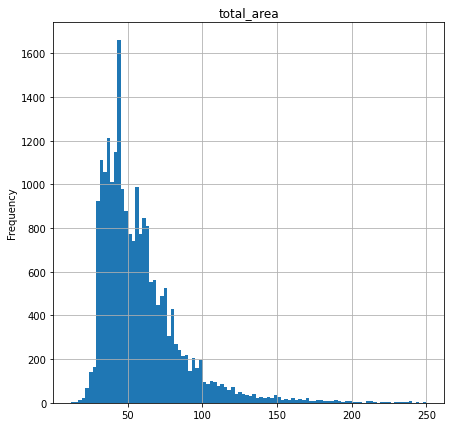

count    21737.000000
mean        58.261723
std         27.351189
min         12.000000
25%         40.000000
50%         51.700000
75%         68.500000
max        250.000000
Name: total_area, dtype: float64

In [79]:
# строим распределение общей площади

analysis['total_area'].plot(kind='hist', bins=100, figsize=(7, 7), title='total_area', grid=True)
plt.show()
analysis['total_area'].describe()

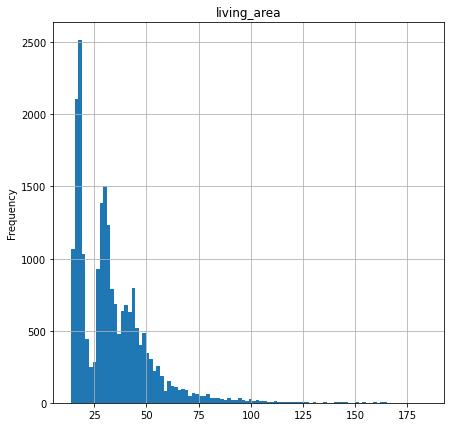

count    21737.000000
mean        33.636210
std         18.024881
min         14.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        184.000000
Name: living_area, dtype: float64

In [80]:
# строим распределение жилплощадей

analysis['living_area'].plot(kind='hist', bins=100, figsize=(7, 7), title='living_area', grid=True)
plt.show()
analysis['living_area'].describe()

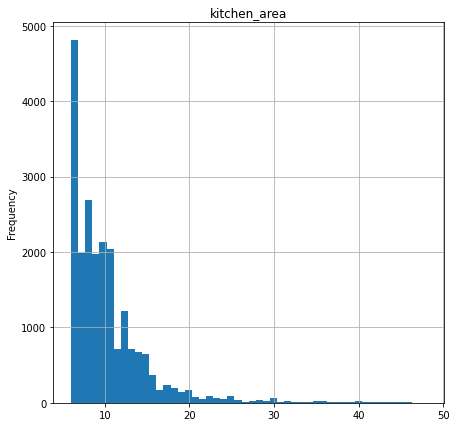

count    21737.000000
mean        10.286375
std          4.903216
min          6.000000
25%          7.000000
50%          9.000000
75%         11.800000
max         48.000000
Name: kitchen_area, dtype: float64

In [81]:
# строим распределение площадей кухни

analysis['kitchen_area'].plot(kind='hist', bins=50, figsize=(7, 7), title='kitchen_area', grid=True)
plt.show()
analysis['kitchen_area'].describe()

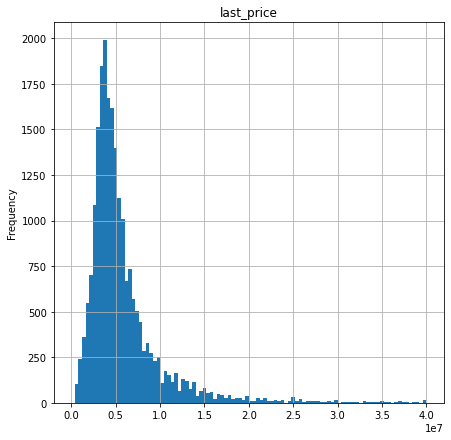

count    2.173700e+04
mean     5.824364e+06
std      4.377798e+06
min      1.219000e+04
25%      3.420000e+06
50%      4.600000e+06
75%      6.650000e+06
max      4.000000e+07
Name: last_price, dtype: float64

In [82]:
# строим распределение цен

analysis['last_price'].plot(kind='hist', bins=100, figsize=(7, 7), title='last_price', grid=True)
plt.show()
analysis['last_price'].describe()

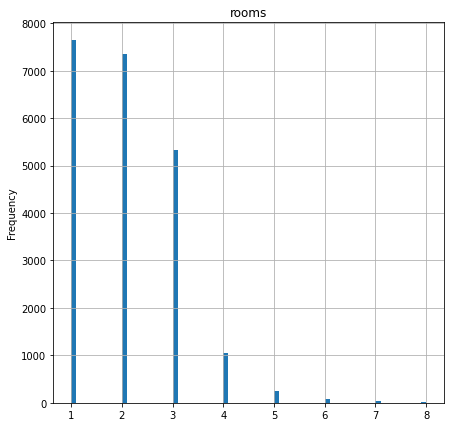

count    21737.000000
mean         2.047845
std          0.997103
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

In [83]:
# строим распределение данных в столбце с кол-вом комнат

analysis['rooms'].plot(kind='hist', bins=70, figsize=(7, 7), title='rooms', grid=True)
plt.show()
analysis['rooms'].describe()

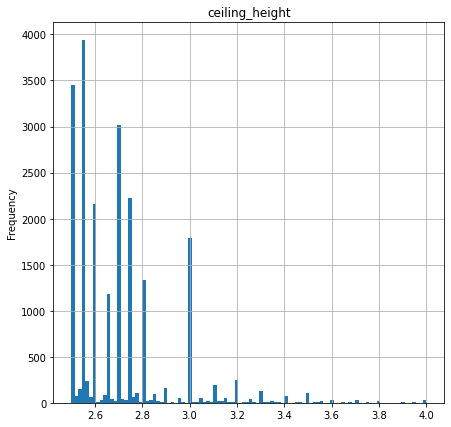

count    21737.000000
mean         2.700992
std          0.215427
min          2.500000
25%          2.550000
50%          2.650000
75%          2.750000
max          4.000000
Name: ceiling_height, dtype: float64

In [84]:
# строим распределение высоты квартир

analysis['ceiling_height'].plot(kind='hist', bins=100, figsize=(7, 7), title='ceiling_height', grid=True)
plt.show()
analysis['ceiling_height'].describe()

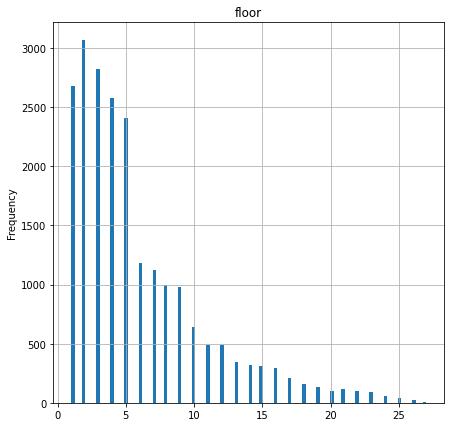

count    21737.000000
mean         5.879652
std          4.842406
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

In [85]:
# строим распределение по этажам

analysis['floor'].plot(kind='hist', bins=100, figsize=(7, 7), title='floor', grid=True)
plt.show()
analysis['floor'].describe()

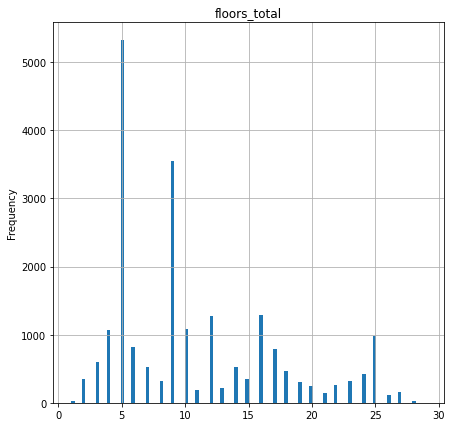

count    21737.000000
mean        10.676772
std          6.517159
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

In [86]:
# строим распределение по этажности домов

analysis['floors_total'].plot(kind='hist', bins=100, figsize=(7, 7), title='floors_total', grid=True)
plt.show()
analysis['floors_total'].describe()

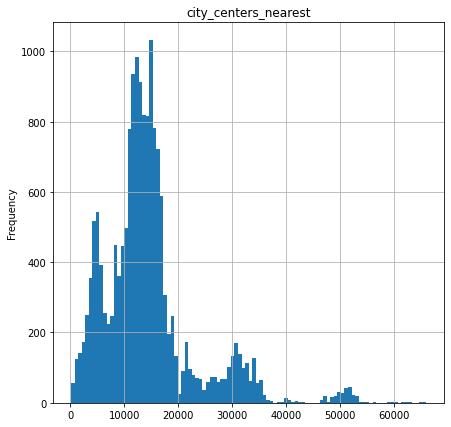

count    16724.000000
mean     14335.397752
std       8641.834515
min        181.000000
25%       9508.000000
50%      13162.000000
75%      16296.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

In [87]:
# строим распределение по расстоянию до центра

analysis['city_centers_nearest'].plot(kind='hist', bins=100, figsize=(7, 7), title='city_centers_nearest', grid=True)
plt.show()
analysis['city_centers_nearest'].describe()

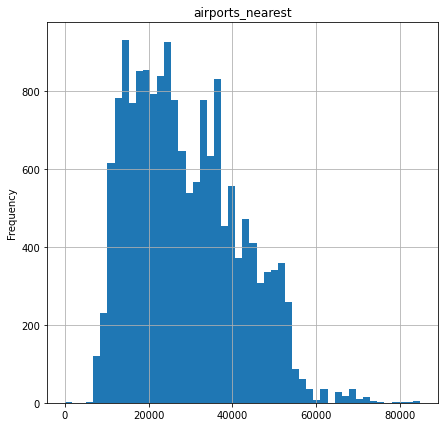

count    16706.000000
mean     28850.272417
std      12707.226958
min          0.000000
25%      18472.000000
50%      26876.000000
75%      37407.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [88]:
# строим распределение по расстоянию до ближайшего аэропорта

analysis['airports_nearest'].plot(kind='hist', bins=50, figsize=(7, 7), title='airports_nearest', grid=True)
plt.show()
analysis['airports_nearest'].describe()

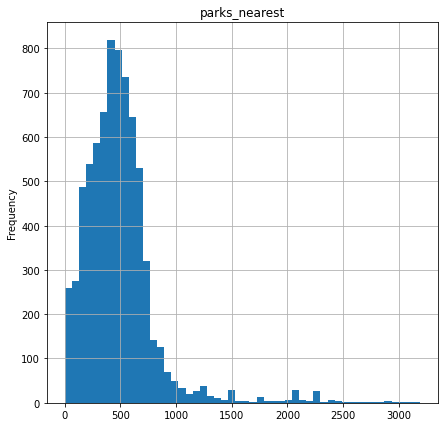

count    7359.000000
mean      490.240114
std       339.242570
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [89]:
# строим распределение по расстоянию до ближайшего парка

analysis['parks_nearest'].plot(kind='hist', bins=50, figsize=(7, 7), title='parks_nearest', grid=True)
plt.show()
analysis['parks_nearest'].describe()

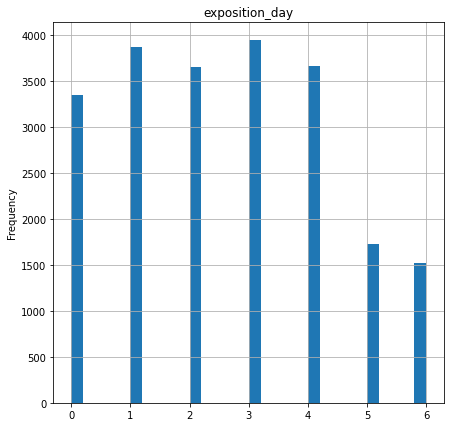

count    21737.000000
mean         2.549662
std          1.783851
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: exposition_day, dtype: float64

In [90]:
# строим распределение по дню размещения

analysis['exposition_day'].plot(kind='hist', bins=30, figsize=(7, 7), title='exposition_day', grid=True)
plt.show()
analysis['exposition_day'].describe()

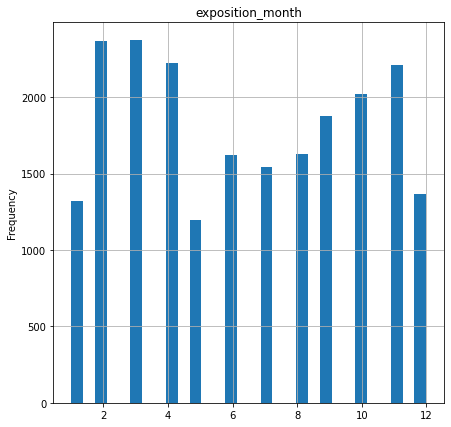

count    21737.000000
mean         6.410820
std          3.460895
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64

In [91]:
# строим распределение по месяцу размещения

analysis['exposition_month'].plot(kind='hist', bins=30, figsize=(7, 7), title='exposition_month', grid=True)
plt.show()
analysis['exposition_month'].describe()

**1. Пики на гистограммах с высотой потолков, жилплощадью и площадью кухни свидетельствуют о большом количестве однотипных квартир в определённых диапазонах.**
 - Среднее арифметическое (выс. пот.): 2.7 
 - Медиана (выс. пот.): 2.65  
 - Среднее арифметическое (жилплощадь): 33.64   
 - Медиана (жилплощадь): 30 
 - Среднее арифметическое (кухня): 10.29 
 - Медиана (кухня): 9  
 
**2. Объявления о продаже квартиры чаще всего размещают по будням и неохотно размещают летом или под новый год.**  

**3. Гистограмма с этажом квартиры имеет пик в диапазоне от 0 до 5 что может указывать на продажу квартир в пятиэтажных домах (кол-во которых велико).**
 - Среднее арифметическое: 5.88
 - Медиана: 4  
 
**4. Гистограмма с общим кол-вом этажей имеет два пика в области наиболее часто встречающихся домов (5 и 9 этажей).** 
 - Среднее арифметическое: 10.68
 - Медиана: 9  
 
**5. Гистограммы с расстоянием до центра, ближайшего аэропорта и ближайшего парка имеют уменьшенный частотный масштаб. Это может происходить в следствие того что квартира находится в центре, в данном населённом пункте нет аэропорта или парка.**  

**Центр**
 - Среднее арифметическое: 14335.4
 - Медиана: 13162  
 
**Аэропорт**
 - Среднее арифметическое: 28850.27
 - Медиана: 26876  
 
**Парк**
 - Среднее арифметическое: 490.24
 - Медиана: 455

**Изучение скорости продажи квартиры**

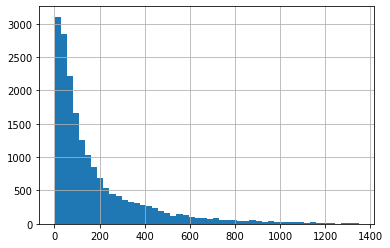

In [92]:
# вводим переменную clear_data чтобы отсечь отрицательные значения и строим гистограмму

len(data.query('days_exposition > 730')) # KFAWJFNWAFA
clear_data = data.query('days_exposition > 0')

# гистограмма

clear_data['days_exposition'].hist(bins=50)
plt.show()

In [93]:
clear_data.reset_index(drop=True, inplace=True)

In [94]:
print(
    'Среднее арифметическое = ',
    clear_data['days_exposition'].describe()['mean'],
    '\n',
    'Медиана = ',
    clear_data['days_exposition'].describe()['50%'],
    sep='',
)

Среднее арифметическое = 181.85109901835253
Медиана = 100.0


In [95]:
# посмотрим статистику

clear_data['days_exposition'].describe()

count    18744.000000
mean       181.851099
std        215.528327
min          1.000000
25%         44.000000
50%        100.000000
75%        235.000000
max       1350.000000
Name: days_exposition, dtype: float64

На основе анализа колонки с кол-вом дней с размещённым объявлением было установлено, что быстрыми продажами можно считать те, которые осуществлялись меньше чем за 43 дня, необычно длинные - которые занимали более 215 дней, обычно продажа занимает около 95 дней. 

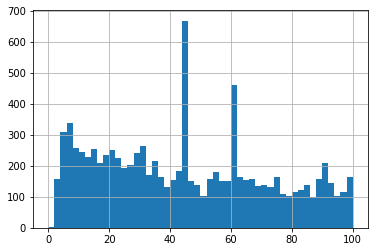

In [96]:
clear_data['days_exposition'].hist(bins=50, range=(0, 100))
plt.show()

Причина появления аномальных пиков здесь заключается в том, что в эти дни платформа снимает объявления.

**Визуализация влияния факторов на стоимость объекта.**

Корреляция: 78.18%


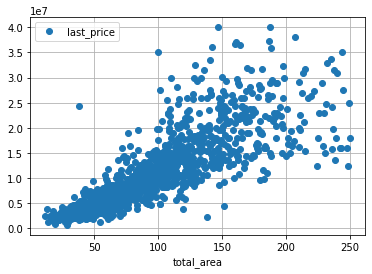

In [97]:
# Зависимость цены от общей площади

data.pivot_table(index='total_area', values='last_price').plot(grid=True, style='o')
print(f'Корреляция: {data["total_area"].corr(data["last_price"]):.2%}')

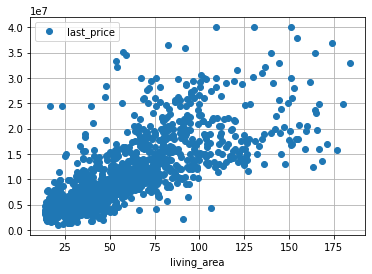

Корреляция: 67.96%


In [98]:
# Зависимость цены от жилой площади

data.pivot_table(index="living_area", values="last_price").plot(grid=True, style="o")
plt.show()
print(f'Корреляция: {data["living_area"].corr(data["last_price"]):.2%}')

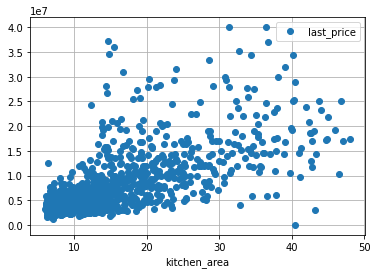

Корреляция: 59.61%


In [99]:
# Зависимость цены от площади кухни

data.pivot_table(index="kitchen_area", values="last_price", aggfunc="median").plot(
    grid=True, style="o"
)
plt.show()

print(f'Корреляция: {data["kitchen_area"].corr(data["last_price"]):.2%}')

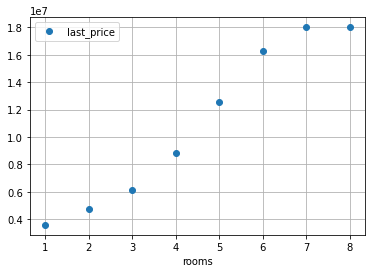

Корреляция: 50.77%


In [100]:
# Зависимость цены от кол-ва комнат

data.pivot_table(index="rooms", values="last_price", aggfunc="median").plot(
    grid=True, style="o"
)
plt.show()

print(f'Корреляция: {data["rooms"].corr(data["last_price"]):.2%}')

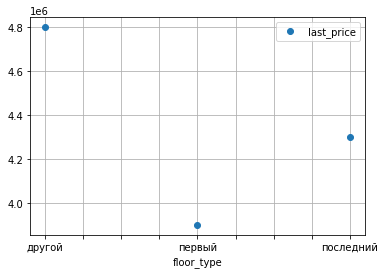

In [101]:
# Зависимость цены от типа этажа

data.pivot_table(index="floor_type", values="last_price", aggfunc="median").plot(
    grid=True, style="o"
)

plt.show()

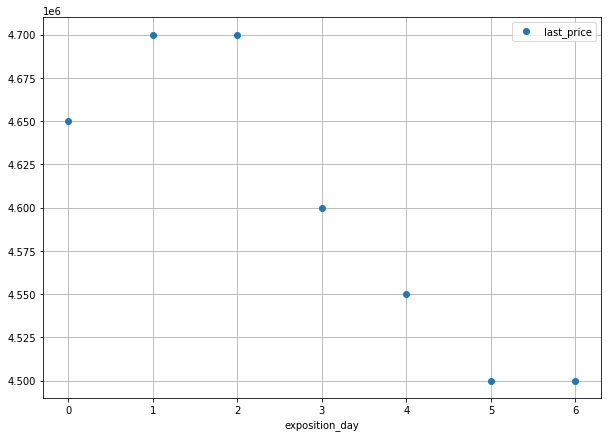

In [102]:
# Зависимость цены от дня размещения объявления

data.pivot_table(
    index="exposition_day", values="last_price", aggfunc="median"
).plot(grid=True, style="o", figsize=(10, 7))

plt.show()

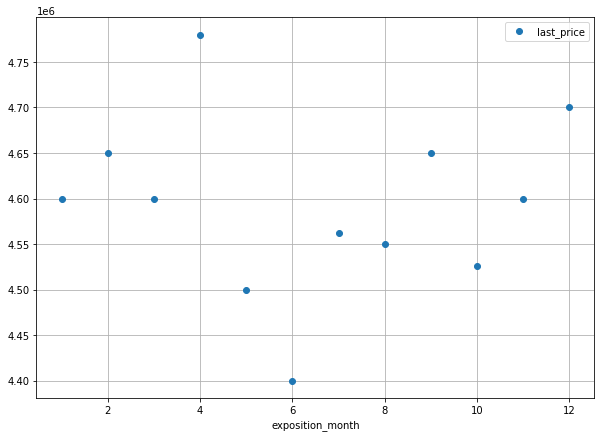

In [103]:
# Зависимость цены от месяца размещения объявления

data.pivot_table(
    index="exposition_month", values="last_price", aggfunc="median"
).plot(grid=True, style="o", figsize=(10, 7))

plt.show()

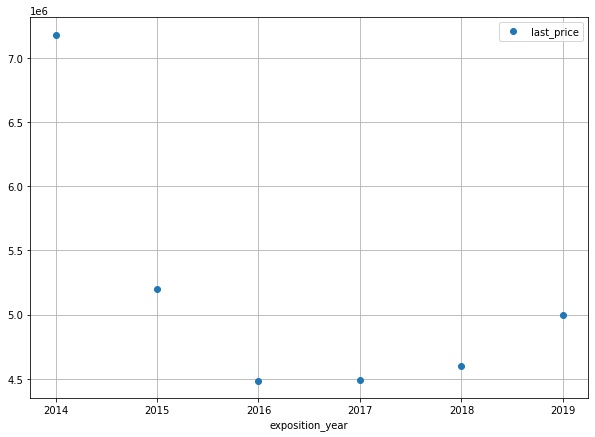

In [104]:
# Зависимость цены от года размещения объявления

data.pivot_table(
    index="exposition_year", values="last_price", aggfunc="median"
).plot(grid=True, style="o", figsize=(10, 7))

plt.show()

**Определение 10 пунктов с наибольшим числом объявлений и вычсиление средней цены квадратного метра.**

In [105]:
# используем сводную таблицу для определения регионов с наибольшим числом объявлений

exposition_counts = clear_data.pivot_table(index='locality_name',
        values='first_day_exposition', aggfunc='count'
        ).sort_values(by='first_day_exposition', ascending=False)

In [106]:
# создание сводной таблицы для расчёта средней цены квадратного метра

local_area_and_price = clear_data.pivot_table(index='locality_name',
        values=['last_price', 'total_area'])

In [107]:
# создаём столбец в исходной таблице

exposition_counts['unit_price'] = local_area_and_price['last_price'] \
    / local_area_and_price['total_area']

In [108]:
# топ 10 пунктов по количеству объявлений

top_10_loc_exp = exposition_counts.head(10)

In [109]:
# топ 10 пунктов по медианной цене квартир

top_10_loc_price = top_10_loc_exp.sort_values(by='unit_price', ascending=False).head(10)

In [110]:
# топ по кол-ву объявлений

display(top_10_loc_exp)

,first_day_exposition,unit_price
locality_name,,
санкт-петербург,12516,110652.303570
поселок мурино,506,83432.778327
поселок шушары,378,75651.783072
всеволожск,311,67376.976838
колпино,297,72879.397126
пушкин,277,103414.445854
поселок парголово,276,87022.908583
деревня кудрово,263,90683.335551
гатчина,256,66499.651345


In [111]:
# топ по цене (в регионах из прошлого топа)

display(top_10_loc_price)

,first_day_exposition,unit_price
locality_name,,
санкт-петербург,12516,110652.303570
пушкин,277,103414.445854
деревня кудрово,263,90683.335551
поселок парголово,276,87022.908583
поселок мурино,506,83432.778327
поселок шушары,378,75651.783072
колпино,297,72879.397126
всеволожск,311,67376.976838
гатчина,256,66499.651345


In [112]:
# Определяем граничные показатели (таблица отсортирована)

print(
f'Наибольшая цена в регионе - {top_10_loc_exp.index[0].upper()} \
составляет: {top_10_loc_exp.loc["санкт-петербург", "unit_price"]:.2f} \
\nНаименьшая цена в регионе - {top_10_loc_exp.index[9].upper()} \
составляет: {top_10_loc_exp.loc["выборг", "unit_price"]:.2f}'
)

Наибольшая цена в регионе - САНКТ-ПЕТЕРБУРГ составляет: 110652.30 
Наименьшая цена в регионе - ВЫБОРГ составляет: 56474.00


**Определение цены 1 км по расстоянию до центра.**

In [113]:
# создание среза по пункту "санкт-петербург"

spb_distance_to_center = data.query(
    'locality_name == "санкт-петербург" and to_center_km.isna() == False and to_center_km != 0'
)[["last_price", "to_center_km"]]

# вызов этих условий понадобился чтобы устранить ошибку при подсчёте среднего значения, в ходе которого возникало значение inf

In [114]:
# вычисление стоимости 1 км

spb_distance_to_center['distance_unit_price'] = spb_distance_to_center['last_price'] \
/ spb_distance_to_center['to_center_km']

display(f'Средняя цена за км до центра: {spb_distance_to_center["distance_unit_price"].mean():.2f}')

'Средняя цена за км до центра: 1037565.71'

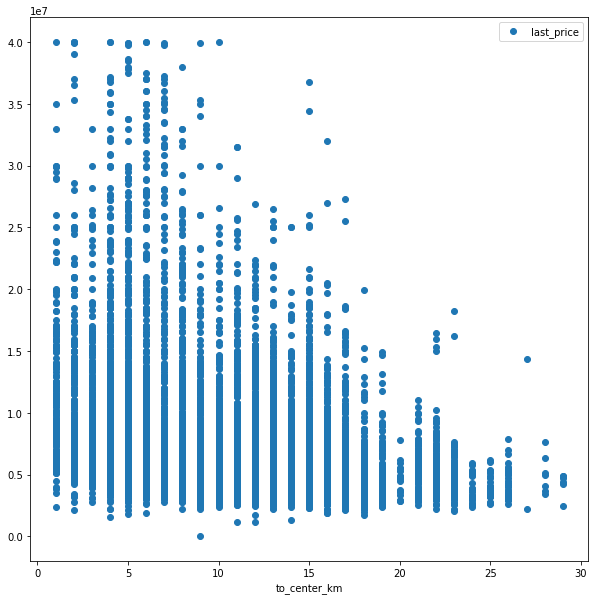

In [115]:
# визуализация зависимости цены от расстояния до центра 

spb_distance_to_center.plot(x='to_center_km', y='last_price', style='o', figsize=(10, 10))
plt.show()

In [116]:
# коэффициент корреляции

print(f'Коэффициент корреляции: {spb_distance_to_center["last_price"].corr(spb_distance_to_center["to_center_km"]):.1f}')

Коэффициент корреляции: -0.4


**Вывод:** Коэффициент корреляции отрицательный, что говорит нам об уменьшении цены жилья при увеличении расстояния до центра населённого пункта.

## Общий вывод

В ходе данного исследования были установлены следующие факты: 
* продаётся большое кол-во однотипного жилья как по площади, так и по кол-ву этажей (преобладают 5- и 9-этажки)
* объявления о продаже квартиры чаще всего размещают с понедельника по пятницу, меньше всего объявлений появляется в мае, январе и декабре (вероятно люди не желают заниматься продажей в преддверии лета или в новогодние праздники).
* продажа зачастую занимает 95 дней, четверть квартир продаётся менее чем за 43 дня, время необычно долгих продаж составляет более 215 дней
* существует положительная зависимость между ценой и площадью квартиры, ценой и кол-вом комнат
* существует отрицательная зависимость между расстоянием до центра населённого пункта и ценой, чем больше расстояние, тем ниже цена квартиры
* выше всего цена квартир которые находятся на этажах отличных от первого и последнего, ниже всего цена первых этажей
* разброс цен уменьшался с каждым годом и стремился к 5 000 000
* больше всего объявлений было размещено в Санкт-Петербурге - 10 826 по сравнению с поселком Мурино (на 2 месте) - 408
* средняя цена квадратного метра выше всего в Санкт-Петербурге - 108 220, на втором месте Пушкин - 104 098, наименее дорогой (из топ 10 пунктов) - Выборг - 56 099
* медианные значения цены выше всего при размещении объявления во вторник и среду, ниже всего в субботу и воскресение